In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal

import gym
from gym import spaces
import data

from stable_baselines.common.policies import MlpLnLstmPolicy
from stable_baselines.common.vec_env import SubprocVecEnv
from stable_baselines import PPO2

import warnings
warnings.filterwarnings('ignore')

import os

Loading the time series ordered by date. In this case, the time series of Apple is loaded

In [2]:
colnames = ['Date', 'Open', 'High', 'Close', 'Low', 'Volume', 'Trades', 'Av_Price']
series = 'apple'
DETREND = True
N_LAST_BARS = 25
TEST_RANDOM = True
LOAD_MODEL = False

In [3]:
data_list = []
data_path = 'data/{}/'.format(series)
for csv in sorted(os.listdir(data_path)):
     data_list.append(pd.read_csv(data_path + csv, header=None))

df = pd.concat(data_list).reset_index(drop=True)

df.columns = colnames
df['Price'] = df['Close']
df.head()

,Date,Open,High,Close,Low,Volume,Trades,Av_Price,Price
0,2004.01.23 09:30:00,3.18,3.22,3.20,3.18,31178,1095,3.203286,3.20
1,2004.01.23 10:00:00,3.20,3.25,3.23,3.20,46228,1642,3.231714,3.23
2,2004.01.23 11:00:00,3.23,3.23,3.23,3.21,32627,1075,3.222429,3.23
3,2004.01.23 12:00:00,3.23,3.24,3.22,3.21,40201,1456,3.227571,3.22
4,2004.01.23 13:00:00,3.22,3.23,3.21,3.21,14798,778,3.218000,3.21


In [4]:
df.tail()

,Date,Open,High,Close,Low,Volume,Trades,Av_Price,Price
26595,2019.03.18 11:00:00,188.22,188.23,187.57,187.18,29966,14378,187.580,187.57
26596,2019.03.18 12:00:00,187.57,187.67,187.42,187.02,19081,9929,187.413,187.42
26597,2019.03.18 13:00:00,187.40,188.10,188.10,187.30,15840,7847,187.763,188.10
26598,2019.03.18 14:00:00,188.09,188.23,187.96,187.71,21181,9887,187.944,187.96
26599,2019.03.18 15:00:00,187.97,188.25,188.03,187.66,31676,17626,187.949,188.03


Show time series price

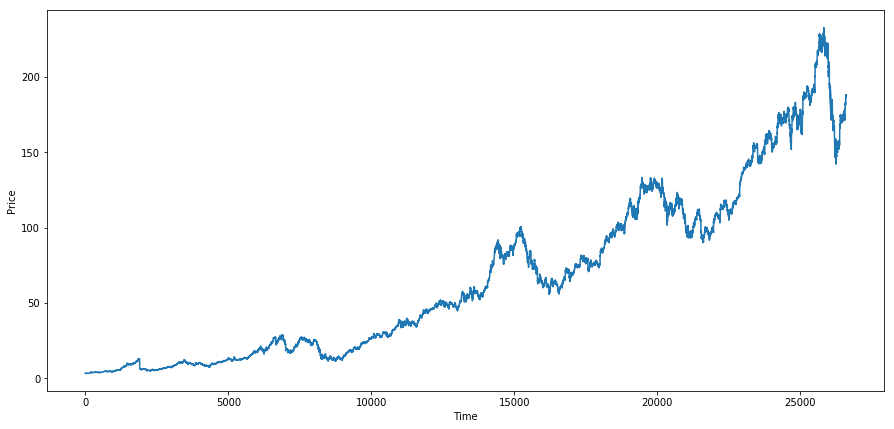

In [5]:
plt.figure(1, figsize=(15,7))
x = np.arange(0, df.shape[0])
y = df['Price']
plt.plot(x, y)
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

Data partitioning in train and test sets

In [6]:
gap_sep = 50
train_perc = 0.8
data_length = df.shape[0]
df_train = df.iloc[:int(data_length*train_perc), :].copy()
df_test = df.iloc[(int(data_length*train_perc) + gap_sep):, :].copy()
df_train.shape, df_test.shape

((21280, 9), (5270, 9))

Function for detrending data, previos log transform is optional

In [7]:
def detrend_data(df, columns, prev_log_transform=True):
    for col in columns_with_trend:
        if prev_log_transform:
            x = np.log1p(df_train[col].values)
        else:
            x = df_train[col].values
        
        df[col] = signal.detrend(x)
        
    return df

Function for adding **new variables**

In [8]:
def add_new_variables(df):
    df['High_rel'] = (df_train['High'] - df_train['Open']) / df_train['Open']
    df['Low_rel'] = (df_train['Low'] - df_train['Open']) / df_train['Open']
    df['Close_rel'] = (df_train['Close'] - df_train['Open']) / df_train['Open']

    df['Max_price_last_12h'] = df['Price'].rolling(12).max()
    df['Min_price_last_12h'] = df['Price'].rolling(12).min()
    df['Mean_price_last_12h'] = df['Price'].rolling(12).mean()
    df['Median_price_last_12h'] = df['Price'].rolling(12).median()
    df['Std_price_last_12h'] = df['Price'].rolling(12).std()

    df['Max_price_last_24h'] = df['Price'].rolling(24).max()
    df['Min_price_last_24h'] = df['Price'].rolling(24).min()
    df['Mean_price_last_24h'] = df['Price'].rolling(24).mean()
    df['Median_price_last_24h'] = df['Price'].rolling(24).median()
    df['Std_price_last_24h'] = df['Price'].rolling(24).std()

    df['Max_price_last_1w'] = df['Price'].rolling(168).max()
    df['Min_price_last_1w'] = df['Price'].rolling(168).min()
    df['Mean_price_last_1w'] = df['Price'].rolling(168).mean()
    df['Median_price_last_1w'] = df['Price'].rolling(168).median()
    df['Std_price_last_1w'] = df['Price'].rolling(168).std()

    df['Max_price_last_1m'] = df['Price'].rolling(720).max()
    df['Min_price_last_1m'] = df['Price'].rolling(720).min()
    df['Mean_price_last_1m'] = df['Price'].rolling(720).mean()
    df['Median_price_last_1m'] = df['Price'].rolling(720).median()
    df['Std_price_last_1m'] = df['Price'].rolling(720).std()
    
    df['Max_price_last_all'] = df['Price'].expanding().max()
    df['Min_price_last_all'] = df['Price'].expanding().min()
    df['Mean_price_last_all'] = df['Price'].expanding().mean()
    df['Median_price_last_all'] = df['Price'].expanding().median()
    df['Std_price_last_all'] = df['Price'].expanding().std()
    
    df = df.fillna(0)
    
    return df

Detreng train set if neccessary. The price is scaled to the original limits

In [9]:
if DETREND:
    max_price = max(df_train['Price'].values)
    min_price = min(df_train['Price'].values)

    columns_with_trend = ['Open', 'High', 'Low', 'Close', 'Av_Price', 'Price']
    df_train = detrend_data(df_train, columns_with_trend)

    df_train['Price'] = MinMaxScaler(feature_range=(min_price, max_price)).fit_transform(df_train['Price'].values.reshape(-1,1))

Add new variables to trainset and testset

In [10]:
df_train = add_new_variables(df_train)
df_test = add_new_variables(df_test)

df_train.shape, df_test.shape

((21280, 37), (5270, 37))

Create agent observations previously for saving training time. These observatios are normalized in incremental way

In [11]:
state_vars = list(set(df_train.columns.values.tolist()) - {'Price', 'Date'})
scaler = MinMaxScaler()

normalized_incr_train = np.zeros((df_train.shape[0], N_LAST_BARS + 1, len(state_vars)))
normalized_incr_test = np.zeros((df_test.shape[0], N_LAST_BARS + 1, len(state_vars)))

for i in np.arange(N_LAST_BARS, df_train.shape[0]):
    norm_series = scaler.fit_transform(df_train[state_vars].values[:(i + 1)])
    normalized_incr_train[i,:,:] = norm_series[-(N_LAST_BARS + 1):,:]

for i in np.arange(N_LAST_BARS, df_test.shape[0]):
    norm_series = scaler.fit_transform(df_test[state_vars].values[:(i + 1)])
    normalized_incr_test[i,:,:] = norm_series[-(N_LAST_BARS + 1):,:]

normalized_incr_train.shape, normalized_incr_test.shape

((21280, 26, 35), (5270, 26, 35))

Show price plot for training data. In this series the price is without trend

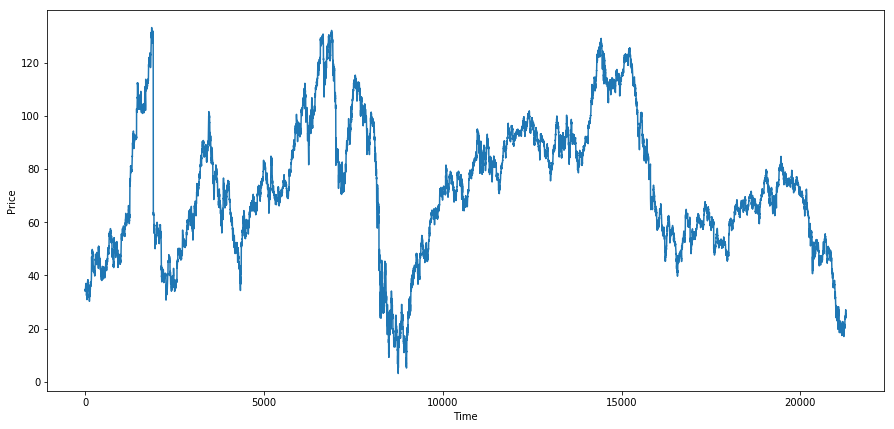

In [12]:
plt.figure(1, figsize=(15,7))
x = np.arange(0, df_train.shape[0])
y = df_train['Price']
plt.plot(x, y)
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

Show pice for test data

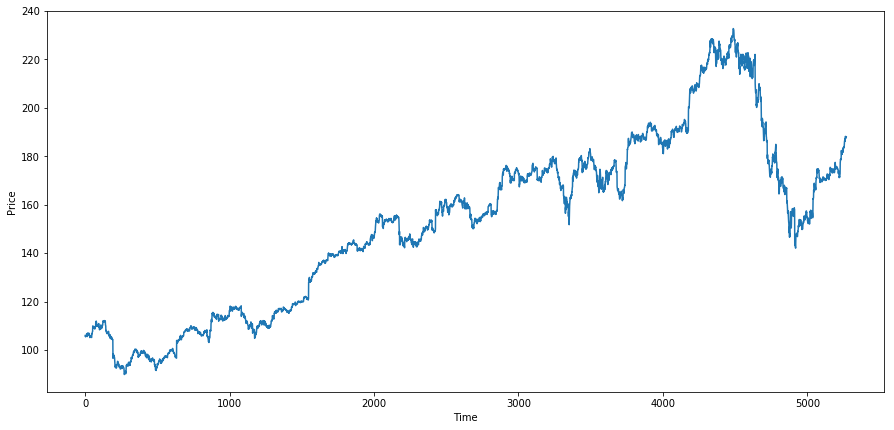

In [13]:
plt.figure(1, figsize=(15,7))
x = np.arange(0, df_test.shape[0])
y = df_test['Price']
plt.plot(x, y)
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

Create trading environment with gym library

In [14]:
class TradingEnvironment(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, price_series, obs_norm, initial_cash=10000, broker_commission=0.001, n_last_bars=25,
                 quantity = 10, max_shares = 10000, noise=False, noise_perc=0.75, max_cash_proportion = 5):
        super(TradingEnvironment, self).__init__()
        
        self.price_series = price_series.reset_index(drop=True)
        self.obs_norm = obs_norm
        self.n_last_bars = n_last_bars
        self.initial_cash = initial_cash
        self.broker_commission = broker_commission
        
        self.noise = noise
        self.noise_perc = noise_perc
        
        self.max_shares = max_shares
        self.max_cash = initial_cash * max_cash_proportion
        self.max_net_worth = self.max_cash
        
        self.quantity = quantity
        self.action_space = spaces.MultiDiscrete([3, quantity])
        
        self.obs_shape = (38, n_last_bars + 1)
        self.observation_space = spaces.Box(low=0,
                                            high=1,
                                            shape=self.obs_shape,
                                            dtype=np.float16)
        self.episode_count = 0
        
    def _next_observation(self):
        obs = np.transpose(self.obs_norm[self.timestep + self.n_last_bars])

        obs = np.append(obs, self.account_history[:, -(self.n_last_bars + 1):], axis=0)
        obs = obs.reshape(self.obs_shape)
        return obs
        
    def reset(self):
        self.episode_steps = 0
        self.timestep = 0
        self.profit = 0.0
        self.cash = self.initial_cash
        self.net_worth = self.initial_cash
            
        self.n_shares = 0
        
        self.buy_actions = 0
        self.sell_actions = 0
        self.hold_actions = 0

        self.account_history = np.repeat([
            [self.cash / self.max_cash],
            [self.n_shares / self.max_shares],
            [self.net_worth / self.max_net_worth]
        ], self.n_last_bars + 1, axis=1)
        
        self.steps_left = self.price_series.shape[0] - self.n_last_bars - 1

        return self._next_observation()
    
    def _get_current_price(self):
        return self.price_series[self.timestep + self.n_last_bars]
    
    def _take_action(self, action, current_price):
        main_action = action[0]
        quantity = action[1] / self.quantity
        if main_action < 2 and self.noise:
            if random.uniform(0,1) <= self.noise_perc:
                main_action = 2

        n_shares_bought = 0
        n_shares_sold = 0
        cost = 0
        sales = 0
        self.valid_action = True

        if main_action == 0:
            max_n_shares_to_buy = self.cash / (current_price * (1 + self.broker_commission))
            n_shares_expected = (self.cash * quantity) / (current_price * (1 + self.broker_commission))
            
            if max_n_shares_to_buy > n_shares_expected:
                n_shares_bought = int(n_shares_expected)
            else:
                n_shares_bought = int(max_n_shares_to_buy)
            
            if n_shares_bought > 0:
                self.buy_actions += 1
            else:
                self.hold_actions += 1
                self.valid_action = False
                
            cost = n_shares_bought * current_price * (1 + self.broker_commission)

            self.n_shares += n_shares_bought
            self.cash -= cost

        elif main_action == 1:
            n_shares_expected = self.n_shares * quantity
                                      
            if self.n_shares > n_shares_expected:
                n_shares_sold = int(np.ceil(n_shares_expected))
            else:
                n_shares_sold = self.n_shares
            
            if n_shares_sold > 0:
                self.sell_actions += 1
            else:
                self.hold_actions += 1
                self.valid_action = False
                
            sales = n_shares_sold * current_price * (1 - self.broker_commission)

            self.n_shares -= n_shares_sold
            self.cash += sales
            
        else:
            self.hold_actions += 1
            self.valid_action = False

        self.net_worth = self.cash + self.n_shares * current_price

        self.account_history = np.append(self.account_history, [
            [self.cash / self.max_cash],
            [self.n_shares / self.max_shares],
            [self.net_worth / self.max_net_worth]
        ], axis=1)
        
    def step(self, action):
        current_price = self._get_current_price()
        done = False

        prev_net_worth = self.net_worth

        self._take_action(action, current_price)

        self.steps_left -= 1
        self.timestep += 1
        self.episode_steps += 1
        
        net_worth_difference = self.net_worth - prev_net_worth
        self.profit += net_worth_difference
        reward = net_worth_difference
        
        if self.steps_left == 0:
            print('----------------------------------------------------------------------------')
            print('Episode {} end. Profit: {}. Net Worth: {}. Hold Actions: {}. Buy Actions: {} \
                  . Sell Actions: {}'.format(self.episode_count,
                                             self.profit,
                                             self.net_worth,
                                             self.hold_actions,
                                             self.buy_actions,
                                             self.sell_actions))
            print('----------------------------------------------------------------------------')
            self.reset()
            done = True
            obs = False
            self.episode_count += 1
            
        elif self.steps_left % 500 == 0:
            print('Episode step {}. Profit: {}. Net Worth: {}. Shares: {}'.format(self.episode_steps,
                                             self.profit,
                                             self.net_worth,
                                             self.n_shares))
        
        if not done:
            obs = self._next_observation()

        return obs, reward, done, {}

Test environment with random actions

In [15]:
if TEST_RANDOM:
    trading_env = TradingEnvironment(df_train.Price,
                                     normalized_incr_train,
                                     noise=False,
                                     quantity=4)
    obs = trading_env.reset()
    done = False
    while not done:
        action = trading_env.action_space.sample()
        obs, reward, done, _ = trading_env.step(action)

Episode step 254. Profit: -903.7785630728649. Net Worth: 9096.221436927135. Shares: 120
Episode step 754. Profit: -641.1904747808821. Net Worth: 9358.809525219118. Shares: 137
Episode step 1254. Profit: 1370.8595175974242. Net Worth: 11370.859517597424. Shares: 16
Episode step 1754. Profit: 2567.2430554979874. Net Worth: 12567.243055497987. Shares: 100
Episode step 2254. Profit: -6261.4738609241795. Net Worth: 3738.5261390758174. Shares: 61
Episode step 2754. Profit: -6178.346168671004. Net Worth: 3821.653831328983. Shares: 19
Episode step 3254. Profit: -4928.47598117549. Net Worth: 5071.52401882449. Shares: 0
Episode step 3754. Profit: -6252.59063831489. Net Worth: 3747.40936168509. Shares: 39
Episode step 4254. Profit: -7226.044892917661. Net Worth: 2773.955107082331. Shares: 31
Episode step 4754. Profit: -6448.396604949896. Net Worth: 3551.6033950500964. Shares: 37
Episode step 5254. Profit: -6450.626037508317. Net Worth: 3549.3739624916825. Shares: 49
Episode step 5754. Profit: -62

Train environment with PPO using LSTM + MLP policy. Noise action imputed: 80%

In [16]:
n_cpu = 5
env = TradingEnvironment(df_train.Price,
                         normalized_incr_train,
                         initial_cash = 25000,
                         quantity = 4,
                         max_cash_proportion = 10,
                         broker_commission=0.0,
                         n_last_bars=N_LAST_BARS,
                         noise=True,
                         noise_perc=0.8)
env = SubprocVecEnv([lambda: env for i in range(n_cpu)])
model = PPO2(MlpLnLstmPolicy, env, nminibatches=1, verbose=0, tensorboard_log="./runs/")

Episode step 254. Profit: 3900.266792760587. Net Worth: 28900.266792760587. Shares: 264
Episode step 254. Profit: 2705.350567696878. Net Worth: 27705.350567696878. Shares: 2
Episode step 254. Profit: 9227.282311697185. Net Worth: 34227.282311697185. Shares: 93
Episode step 254. Profit: 4823.800223756218. Net Worth: 29823.800223756218. Shares: 621
Episode step 254. Profit: 6769.702186273233. Net Worth: 31769.702186273233. Shares: 258
Episode step 754. Profit: 971.6117225403868. Net Worth: 25971.611722540387. Shares: 16
Episode step 754. Profit: 8099.510600207483. Net Worth: 33099.51060020748. Shares: 309
Episode step 754. Profit: 3038.071606141879. Net Worth: 28038.07160614188. Shares: 9
Episode step 754. Profit: 5371.974235651996. Net Worth: 30371.974235651996. Shares: 435
Episode step 754. Profit: 16908.787305772858. Net Worth: 41908.78730577286. Shares: 174
Episode step 1254. Profit: 4735.784622907711. Net Worth: 29735.78462290771. Shares: 265
Episode step 1254. Profit: 10529.9469091

Episode step 9254. Profit: -4127.30998687361. Net Worth: 20872.690013126346. Shares: 126
Episode step 9254. Profit: 64271.420185112045. Net Worth: 89271.42018511205. Shares: 1558
Episode step 9754. Profit: -237.80741113320255. Net Worth: 24762.192588866754. Shares: 81
Episode step 9754. Profit: -2393.500380076146. Net Worth: 22606.499619923852. Shares: 136
Episode step 9754. Profit: 104154.14332861199. Net Worth: 129154.14332861199. Shares: 1521
Episode step 9754. Profit: 97673.29119724827. Net Worth: 122673.29119724827. Shares: 842
Episode step 9754. Profit: 79365.95353726465. Net Worth: 104365.95353726465. Shares: 44
Episode step 10254. Profit: 133928.43184714508. Net Worth: 158928.43184714508. Shares: 21
Episode step 10254. Profit: 97380.80349980413. Net Worth: 122380.80349980413. Shares: 620
Episode step 10254. Profit: 1031.736767367831. Net Worth: 26031.736767367787. Shares: 299
Episode step 10254. Profit: -4154.930587455818. Net Worth: 20845.06941254418. Shares: 133
Episode step 

Episode step 18254. Profit: -6044.977387657704. Net Worth: 18955.022612342294. Shares: 226
Episode step 18754. Profit: 110618.12433375826. Net Worth: 135618.12433375826. Shares: 2026
Episode step 18754. Profit: 8285.42662812255. Net Worth: 33285.42662812251. Shares: 135
Episode step 18754. Profit: 70778.14214807733. Net Worth: 95778.14214807733. Shares: 1382
Episode step 18754. Profit: -5834.580172078318. Net Worth: 19165.41982792168. Shares: 66
Episode step 18754. Profit: 103249.79973828484. Net Worth: 128249.79973828484. Shares: 444
Episode step 19254. Profit: 93128.39526235969. Net Worth: 118128.39526235969. Shares: 1343
Episode step 19254. Profit: 106536.47974050068. Net Worth: 131536.47974050068. Shares: 1634
Episode step 19254. Profit: -6604.729643823795. Net Worth: 18395.270356176203. Shares: 42
Episode step 19254. Profit: 73831.65010083711. Net Worth: 98831.65010083711. Shares: 1153
Episode step 19254. Profit: 9698.005527907822. Net Worth: 34698.00552790778. Shares: 14
Episode 

Episode step 4754. Profit: 40256.63389847396. Net Worth: 65256.63389847396. Shares: 718
Episode step 5254. Profit: -2659.75689041202. Net Worth: 22340.24310958798. Shares: 171
Episode step 5254. Profit: 16511.229204234274. Net Worth: 41511.229204234274. Shares: 146
Episode step 5254. Profit: 46321.65254588159. Net Worth: 71321.65254588159. Shares: 902
Episode step 5254. Profit: 44859.86718051454. Net Worth: 69859.86718051454. Shares: 936
Episode step 5254. Profit: 10535.566018367404. Net Worth: 35535.566018367404. Shares: 23
Episode step 5754. Profit: 58050.15026987197. Net Worth: 83050.15026987197. Shares: 134
Episode step 5754. Profit: 56979.72746855805. Net Worth: 81979.72746855805. Shares: 230
Episode step 5754. Profit: 2433.9841186719314. Net Worth: 27433.98411867193. Shares: 313
Episode step 5754. Profit: 13737.268921865762. Net Worth: 38737.26892186576. Shares: 259
Episode step 5754. Profit: 21788.516048091435. Net Worth: 46788.516048091435. Shares: 268
Episode step 6254. Profit

Episode step 14254. Profit: 33313.43884374874. Net Worth: 58313.43884374874. Shares: 17
Episode step 14254. Profit: 160340.94838904234. Net Worth: 185340.94838904234. Shares: 153
Episode step 14254. Profit: 39625.98433592969. Net Worth: 64625.984335929694. Shares: 466
Episode step 14254. Profit: 45031.53017651169. Net Worth: 70031.53017651169. Shares: 51
Episode step 14754. Profit: 43655.09013342439. Net Worth: 68655.0901334244. Shares: 139
Episode step 14754. Profit: 32852.452633731154. Net Worth: 57852.452633731154. Shares: 202
Episode step 14754. Profit: 168414.0893633297. Net Worth: 193414.0893633297. Shares: 683
Episode step 14754. Profit: 28112.14172733984. Net Worth: 53112.14172733984. Shares: 55
Episode step 14754. Profit: 42334.79615839917. Net Worth: 67334.79615839917. Shares: 484
Episode step 15254. Profit: 30028.318583367676. Net Worth: 55028.318583367676. Shares: 0
Episode step 15254. Profit: 178748.2818842929. Net Worth: 203748.2818842929. Shares: 701
Episode step 15254. 

Episode step 754. Profit: -2330.159771566083. Net Worth: 22669.840228433917. Shares: 379
Episode step 754. Profit: 1506.1046519680203. Net Worth: 26506.10465196802. Shares: 559
Episode step 754. Profit: 2594.9574158043433. Net Worth: 27594.957415804343. Shares: 444
Episode step 754. Profit: 2427.5334762044113. Net Worth: 27427.53347620441. Shares: 395
Episode step 1254. Profit: 17993.132056866685. Net Worth: 42993.132056866685. Shares: 131
Episode step 1254. Profit: 12950.942542892444. Net Worth: 37950.942542892444. Shares: 477
Episode step 1254. Profit: -140.97197393709212. Net Worth: 24859.028026062908. Shares: 252
Episode step 1254. Profit: 16197.133248686863. Net Worth: 41197.13324868686. Shares: 517
Episode step 1254. Profit: 7920.120163354586. Net Worth: 32920.120163354586. Shares: 413
Episode step 1754. Profit: 16730.660823278144. Net Worth: 41730.660823278144. Shares: 311
Episode step 1754. Profit: 24236.047723915297. Net Worth: 49236.0477239153. Shares: 256
Episode step 1754. 

Episode step 9754. Profit: 20463.8493771918. Net Worth: 45463.8493771918. Shares: 244
Episode step 10254. Profit: 26168.595411602364. Net Worth: 51168.595411602364. Shares: 0
Episode step 10254. Profit: -3671.876454792953. Net Worth: 21328.123545207047. Shares: 52
Episode step 10254. Profit: 5568.731165393565. Net Worth: 30568.731165393565. Shares: 52
Episode step 10254. Profit: 43734.63486041967. Net Worth: 68734.63486041967. Shares: 178
Episode step 10254. Profit: 24827.75165464716. Net Worth: 49827.75165464716. Shares: 134
Episode step 10754. Profit: 27867.532826898372. Net Worth: 52867.53282689837. Shares: 182
Episode step 10754. Profit: 6990.348791430704. Net Worth: 31990.348791430704. Shares: 60
Episode step 10754. Profit: 47422.545908096596. Net Worth: 72422.5459080966. Shares: 2
Episode step 10754. Profit: 26393.013732398278. Net Worth: 51393.01373239828. Shares: 45
Episode step 10754. Profit: -1530.248183846721. Net Worth: 23469.75181615328. Shares: 6
Episode step 11254. Profi

Episode step 19254. Profit: 15311.516532002192. Net Worth: 40311.51653200219. Shares: 17
Episode step 19254. Profit: -3225.541452278474. Net Worth: 21774.458547721526. Shares: 171
Episode step 19254. Profit: 27883.490938071423. Net Worth: 52883.49093807142. Shares: 525
Episode step 19254. Profit: 12010.392046389214. Net Worth: 37010.392046389214. Shares: 555
Episode step 19754. Profit: 16.26515772053608. Net Worth: 25016.265157720536. Shares: 45
Episode step 19754. Profit: 11773.17284310054. Net Worth: 36773.17284310054. Shares: 396
Episode step 19754. Profit: 30457.92130468697. Net Worth: 55457.92130468697. Shares: 7
Episode step 19754. Profit: 35021.15072410906. Net Worth: 60021.15072410906. Shares: 778
Episode step 19754. Profit: 14241.93727625953. Net Worth: 39241.93727625953. Shares: 128
Episode step 20254. Profit: -525.9116014707579. Net Worth: 24474.088398529242. Shares: 29
Episode step 20254. Profit: 9116.760257598566. Net Worth: 34116.760257598566. Shares: 510
Episode step 202

Episode step 5754. Profit: -111.62108551063648. Net Worth: 24888.378914489364. Shares: 170
Episode step 5754. Profit: 9386.5142025448. Net Worth: 34386.5142025448. Shares: 200
Episode step 5754. Profit: 54768.18430205944. Net Worth: 79768.18430205944. Shares: 700
Episode step 6254. Profit: 57546.62646663026. Net Worth: 82546.62646663026. Shares: 230
Episode step 6254. Profit: 20585.15330931959. Net Worth: 45585.15330931959. Shares: 276
Episode step 6254. Profit: 11173.496708777406. Net Worth: 36173.496708777406. Shares: 86
Episode step 6254. Profit: 223.0155927839187. Net Worth: 25223.01559278392. Shares: 26
Episode step 6254. Profit: 25920.608925127584. Net Worth: 50920.608925127584. Shares: 21
Episode step 6754. Profit: 6651.074914968252. Net Worth: 31651.074914968252. Shares: 171
Episode step 6754. Profit: 17125.34950950631. Net Worth: 42125.34950950631. Shares: 198
Episode step 6754. Profit: 21442.595881274843. Net Worth: 46442.59588127484. Shares: 368
Episode step 6754. Profit: 37

Episode step 14754. Profit: 130901.84029511112. Net Worth: 155901.84029511112. Shares: 1168
Episode step 15254. Profit: 135597.6727369732. Net Worth: 160597.6727369732. Shares: 755
Episode step 15254. Profit: 109106.5740464773. Net Worth: 134106.5740464773. Shares: 974
Episode step 15254. Profit: 117610.31230794685. Net Worth: 142610.31230794685. Shares: 144
Episode step 15254. Profit: 86567.40198811161. Net Worth: 111567.40198811161. Shares: 778
Episode step 15254. Profit: -5099.696730926282. Net Worth: 19900.30326907371. Shares: 70
Episode step 15754. Profit: 71225.29565828326. Net Worth: 96225.29565828326. Shares: 1046
Episode step 15754. Profit: 60126.01767353795. Net Worth: 85126.01767353795. Shares: 393
Episode step 15754. Profit: -9347.211922609631. Net Worth: 15652.78807739036. Shares: 48
Episode step 15754. Profit: 99010.04388498585. Net Worth: 124010.04388498585. Shares: 460
Episode step 15754. Profit: 94509.2066724402. Net Worth: 119509.2066724402. Shares: 1341
Episode step 

Episode step 1254. Profit: 7915.430512960258. Net Worth: 32915.43051296026. Shares: 264
Episode step 1754. Profit: 23565.49357903497. Net Worth: 48565.49357903497. Shares: 373
Episode step 1754. Profit: 46711.73926263189. Net Worth: 71711.73926263189. Shares: 249
Episode step 1754. Profit: 26289.505643563825. Net Worth: 51289.505643563825. Shares: 111
Episode step 1754. Profit: 28833.67172993603. Net Worth: 53833.67172993603. Shares: 165
Episode step 1754. Profit: 34070.652735238735. Net Worth: 59070.652735238735. Shares: 162
Episode step 2254. Profit: 4412.194189571535. Net Worth: 29412.194189571535. Shares: 821
Episode step 2254. Profit: -4694.963590031439. Net Worth: 20305.03640996856. Shares: 75
Episode step 2254. Profit: 7332.198210012379. Net Worth: 32332.19821001238. Shares: 632
Episode step 2254. Profit: 11728.225687710095. Net Worth: 36728.225687710095. Shares: 1058
Episode step 2254. Profit: -4151.157376336923. Net Worth: 20848.842623663077. Shares: 545
Episode step 2754. Pro

Episode step 10754. Profit: 96011.06735546727. Net Worth: 121011.06735546727. Shares: 1332
Episode step 10754. Profit: 14129.448173729506. Net Worth: 39129.44817372951. Shares: 482
Episode step 10754. Profit: 86431.2134673415. Net Worth: 111431.2134673415. Shares: 111
Episode step 11254. Profit: 16556.50397845352. Net Worth: 41556.50397845352. Shares: 403
Episode step 11254. Profit: 88899.17317699702. Net Worth: 113899.17317699702. Shares: 1134
Episode step 11254. Profit: 30768.965064140255. Net Worth: 55768.96506414026. Shares: 504
Episode step 11254. Profit: 112444.41342234422. Net Worth: 137444.41342234422. Shares: 1273
Episode step 11254. Profit: 222575.38173181738. Net Worth: 247575.38173181738. Shares: 280
Episode step 11754. Profit: 81465.26564549978. Net Worth: 106465.26564549978. Shares: 923
Episode step 11754. Profit: 27419.286825121373. Net Worth: 52419.28682512138. Shares: 400
Episode step 11754. Profit: 15119.73583883141. Net Worth: 40119.73583883141. Shares: 438
Episode s

Episode step 19754. Profit: 222203.76591947832. Net Worth: 247203.76591947832. Shares: 1938
Episode step 19754. Profit: 135894.34955483442. Net Worth: 160894.34955483442. Shares: 1228
Episode step 20254. Profit: 95746.047366067. Net Worth: 120746.047366067. Shares: 2190
Episode step 20254. Profit: 9939.427404302209. Net Worth: 34939.42740430221. Shares: 468
Episode step 20254. Profit: 164318.72114915776. Net Worth: 189318.72114915776. Shares: 3441
Episode step 20254. Profit: 61237.417831031635. Net Worth: 86237.41783103163. Shares: 1163
Episode step 20254. Profit: 25676.336104750975. Net Worth: 50676.33610475098. Shares: 448
Episode step 20754. Profit: 7298.017075474574. Net Worth: 32298.017075474574. Shares: 642
Episode step 20754. Profit: 162611.79259601273. Net Worth: 187611.79259601273. Shares: 3501
Episode step 20754. Profit: 59754.4239500393. Net Worth: 84754.4239500393. Shares: 1238
Episode step 20754. Profit: 99602.33327614533. Net Worth: 124602.33327614533. Shares: 2135
Episod

Episode step 6254. Profit: 30847.352637365882. Net Worth: 55847.35263736588. Shares: 568
Episode step 6754. Profit: 71976.87747839441. Net Worth: 96976.87747839441. Shares: 497
Episode step 6754. Profit: 47545.78399279647. Net Worth: 72545.78399279647. Shares: 399
Episode step 6754. Profit: 41183.979039283426. Net Worth: 66183.97903928343. Shares: 405
Episode step 6754. Profit: 65835.18672348953. Net Worth: 90835.18672348953. Shares: 721
Episode step 6754. Profit: 139751.23253931306. Net Worth: 164751.23253931306. Shares: 621
Episode step 7254. Profit: 34040.92255854626. Net Worth: 59040.92255854626. Shares: 720
Episode step 7254. Profit: 40710.12860778082. Net Worth: 65710.12860778082. Shares: 169
Episode step 7254. Profit: 29178.697221152674. Net Worth: 54178.69722115267. Shares: 497
Episode step 7254. Profit: 55455.03953133724. Net Worth: 80455.03953133724. Shares: 866
Episode step 7254. Profit: 100507.06736414028. Net Worth: 125507.06736414028. Shares: 1523
Episode step 7754. Profi

Episode step 15754. Profit: 14290.572597470407. Net Worth: 39290.57259747041. Shares: 488
Episode step 15754. Profit: 126068.0176615736. Net Worth: 151068.0176615736. Shares: 1773
Episode step 15754. Profit: 93072.62708859702. Net Worth: 118072.62708859702. Shares: 387
Episode step 15754. Profit: -1438.3792350154126. Net Worth: 23561.62076498459. Shares: 292
Episode step 16254. Profit: 34470.88560751184. Net Worth: 59470.885607511846. Shares: 1045
Episode step 16254. Profit: 77021.52785365519. Net Worth: 102021.52785365519. Shares: 987
Episode step 16254. Profit: 1369.8160418529624. Net Worth: 26369.816041852966. Shares: 435
Episode step 16254. Profit: 62071.174514192535. Net Worth: 87071.17451419253. Shares: 314
Episode step 16254. Profit: -5719.216620911304. Net Worth: 19280.783379088698. Shares: 321
Episode step 16754. Profit: 83686.98157805389. Net Worth: 108686.98157805389. Shares: 968
Episode step 16754. Profit: 53611.74905392753. Net Worth: 78611.74905392753. Shares: 846
Episode

Episode step 2254. Profit: 8285.739355766535. Net Worth: 33285.739355766535. Shares: 965
Episode step 2254. Profit: 6685.0660429376185. Net Worth: 31685.06604293762. Shares: 25
Episode step 2254. Profit: 3388.6292784257785. Net Worth: 28388.62927842578. Shares: 177
Episode step 2254. Profit: -391.22488772360157. Net Worth: 24608.7751122764. Shares: 115
Episode step 2754. Profit: 35110.23406312738. Net Worth: 60110.23406312738. Shares: 1124
Episode step 2754. Profit: 9539.547094245092. Net Worth: 34539.54709424509. Shares: 667
Episode step 2754. Profit: 6515.481193404958. Net Worth: 31515.481193404958. Shares: 120
Episode step 2754. Profit: 22451.76572121716. Net Worth: 47451.76572121716. Shares: 909
Episode step 2754. Profit: 20986.906189193112. Net Worth: 45986.90618919311. Shares: 885
Episode step 3254. Profit: 25042.65221600698. Net Worth: 50042.65221600698. Shares: 55
Episode step 3254. Profit: 22305.05447077533. Net Worth: 47305.05447077533. Shares: 474
Episode step 3254. Profit: 

Episode step 11254. Profit: 42933.87443460496. Net Worth: 67933.87443460496. Shares: 764
Episode step 11754. Profit: 35449.060574557465. Net Worth: 60449.060574557465. Shares: 521
Episode step 11754. Profit: 44380.52914131416. Net Worth: 69380.52914131415. Shares: 708
Episode step 11754. Profit: 87870.56656634176. Net Worth: 112870.56656634176. Shares: 1206
Episode step 11754. Profit: 39009.234205169436. Net Worth: 64009.23420516944. Shares: 669
Episode step 11754. Profit: 343406.93578901235. Net Worth: 368406.93578901235. Shares: 1396
Episode step 12254. Profit: 36951.047778009255. Net Worth: 61951.047778009255. Shares: 460
Episode step 12254. Profit: 96319.83346716242. Net Worth: 121319.83346716242. Shares: 987
Episode step 12254. Profit: 364440.39352407237. Net Worth: 389440.39352407237. Shares: 138
Episode step 12254. Profit: 50170.36290133451. Net Worth: 75170.3629013345. Shares: 333
Episode step 12254. Profit: 43420.94299282904. Net Worth: 68420.94299282905. Shares: 631
Episode s

Episode step 20754. Profit: 6455.200419343637. Net Worth: 31455.200419343644. Shares: 530
Episode step 20754. Profit: 6778.16295925761. Net Worth: 31778.162959257603. Shares: 470
Episode step 20754. Profit: 54873.99350607995. Net Worth: 79873.99350607995. Shares: 1145
Episode step 20754. Profit: 172901.6214017674. Net Worth: 197901.6214017674. Shares: 824
----------------------------------------------------------------------------
----------------------------------------------------------------------------
----------------------------------------------------------------------------
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Episode 6 end. Profit: -4414.252282312951. Net Worth: 20585.747717687056. Hold Actions: 18640. Buy Actions: 1398                   . Sell Actions: 1216
Episode 6 end. Profit: 244026.304635773. Net Worth: 269026.304635773. Hold Actions: 18589. Buy Actions: 1

Episode step 7254. Profit: 57154.68603974473. Net Worth: 82154.68603974473. Shares: 396
Episode step 7254. Profit: 28443.08322996019. Net Worth: 53443.08322996019. Shares: 40
Episode step 7254. Profit: 5920.872588989572. Net Worth: 30920.872588989572. Shares: 190
Episode step 7754. Profit: 29515.98824825963. Net Worth: 54515.98824825963. Shares: 144
Episode step 7754. Profit: 56320.18394877852. Net Worth: 81320.18394877852. Shares: 11
Episode step 7754. Profit: -5440.018818453831. Net Worth: 19559.98118154617. Shares: 100
Episode step 7754. Profit: 5843.400610282497. Net Worth: 30843.400610282497. Shares: 209
Episode step 7754. Profit: 7920.582831517939. Net Worth: 32920.58283151794. Shares: 41
Episode step 8254. Profit: -6010.564328167478. Net Worth: 18989.43567183252. Shares: 9
Episode step 8254. Profit: -12099.415792680138. Net Worth: 12900.584207319862. Shares: 0
Episode step 8254. Profit: 3616.11427720746. Net Worth: 28616.11427720746. Shares: 135
Episode step 8254. Profit: 17547.

Episode step 16254. Profit: -13700.584427131107. Net Worth: 11299.415572868895. Shares: 198
Episode step 16754. Profit: 11785.346508920702. Net Worth: 36785.3465089207. Shares: 536
Episode step 16754. Profit: -14364.48286630246. Net Worth: 10635.51713369754. Shares: 174
Episode step 16754. Profit: 18451.634223019086. Net Worth: 43451.634223019086. Shares: 730
Episode step 16754. Profit: 52195.461280321615. Net Worth: 77195.46128032162. Shares: 1249
Episode step 16754. Profit: -7644.601638802362. Net Worth: 17355.398361197636. Shares: 299
Episode step 17254. Profit: -13356.010873239458. Net Worth: 11643.989126760542. Shares: 180
Episode step 17254. Profit: 13358.611043885656. Net Worth: 38358.611043885656. Shares: 47
Episode step 17254. Profit: 59650.20769922843. Net Worth: 84650.20769922843. Shares: 1037
Episode step 17254. Profit: 21060.913042476997. Net Worth: 46060.913042477. Shares: 587
Episode step 17254. Profit: -6962.020125313264. Net Worth: 18037.979874686735. Shares: 63
Episod

Episode step 2754. Profit: 43921.04059473029. Net Worth: 68921.0405947303. Shares: 674
Episode step 3254. Profit: 9271.288864226459. Net Worth: 34271.28886422646. Shares: 204
Episode step 3254. Profit: 21511.678452120213. Net Worth: 46511.67845212021. Shares: 511
Episode step 3254. Profit: 40622.000119263816. Net Worth: 65622.00011926382. Shares: 688
Episode step 3254. Profit: 86819.33941945477. Net Worth: 111819.33941945477. Shares: 315
Episode step 3254. Profit: 72060.10264407111. Net Worth: 97060.10264407111. Shares: 1028
Episode step 3754. Profit: 51878.48257306051. Net Worth: 76878.48257306051. Shares: 1119
Episode step 3754. Profit: 9212.723202314082. Net Worth: 34212.72320231408. Shares: 204
Episode step 3754. Profit: 2248.348229269275. Net Worth: 27248.348229269275. Shares: 402
Episode step 3754. Profit: 73928.1577445461. Net Worth: 98928.1577445461. Shares: 1039
Episode step 3754. Profit: 25293.534096939387. Net Worth: 50293.53409693939. Shares: 660
Episode step 4254. Profit: 

Episode step 12254. Profit: 48074.02671897561. Net Worth: 73074.02671897561. Shares: 625
Episode step 12254. Profit: 475871.1044617975. Net Worth: 500871.1044617975. Shares: 4843
Episode step 12254. Profit: 105427.00131596171. Net Worth: 130427.00131596171. Shares: 874
Episode step 12754. Profit: -661.7171960145733. Net Worth: 24338.282803985432. Shares: 16
Episode step 12754. Profit: 46055.21417018445. Net Worth: 71055.21417018445. Shares: 643
Episode step 12754. Profit: 103415.82651792358. Net Worth: 128415.82651792358. Shares: 149
Episode step 12754. Profit: 81448.74314327951. Net Worth: 106448.74314327951. Shares: 703
Episode step 12754. Profit: 476403.74553365086. Net Worth: 501403.74553365086. Shares: 4786
Episode step 13254. Profit: 76788.91376387846. Net Worth: 101788.91376387846. Shares: 469
Episode step 13254. Profit: 1254.421668106368. Net Worth: 26254.421668106374. Shares: 60
Episode step 13254. Profit: 95365.19790082076. Net Worth: 120365.19790082076. Shares: 735
Episode s

----------------------------------------------------------------------------
Episode 8 end. Profit: -9038.749467867834. Net Worth: 15961.250532132171. Hold Actions: 18168. Buy Actions: 1559                   . Sell Actions: 1527
Episode 8 end. Profit: 144200.6782909926. Net Worth: 169200.6782909926. Hold Actions: 18087. Buy Actions: 1626                   . Sell Actions: 1541
Episode 8 end. Profit: 40916.46612559304. Net Worth: 65916.46612559304. Hold Actions: 18194. Buy Actions: 1594                   . Sell Actions: 1466
Episode 8 end. Profit: 51919.62111450943. Net Worth: 76919.62111450943. Hold Actions: 18070. Buy Actions: 1623                   . Sell Actions: 1561
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Episode 8 end. Profit: 4917.3087639193. Net Worth: 29917.3087639193. Hold Actions: 18220. Buy Actions: 1523                   . Sell Actions: 1511
--------------------

Episode step 8254. Profit: 12152.49378963004. Net Worth: 37152.49378963004. Shares: 1316
Episode step 8254. Profit: 2231.7583099732947. Net Worth: 27231.758309973295. Shares: 738
Episode step 8254. Profit: 9416.843598229912. Net Worth: 34416.84359822991. Shares: 1239
Episode step 8254. Profit: 19834.463932721337. Net Worth: 44834.46393272134. Shares: 681
Episode step 8254. Profit: 4182.377001400946. Net Worth: 29182.377001400946. Shares: 818
Episode step 8754. Profit: 18484.682370216673. Net Worth: 43484.68237021667. Shares: 2361
Episode step 8754. Profit: 48450.45559680463. Net Worth: 73450.45559680463. Shares: 3927
Episode step 8754. Profit: -803.7020586675935. Net Worth: 24196.297941332406. Shares: 1377
Episode step 8754. Profit: 11919.771394485811. Net Worth: 36919.77139448581. Shares: 2095
Episode step 8754. Profit: -8026.188022445145. Net Worth: 16973.811977554848. Shares: 544
Episode step 9254. Profit: 50273.00175892674. Net Worth: 75273.00175892674. Shares: 2
Episode step 9254.

Episode step 17254. Profit: 8641.392745871366. Net Worth: 33641.39274587136. Shares: 253
Episode step 17254. Profit: 78405.83339813136. Net Worth: 103405.83339813136. Shares: 1395
Episode step 17254. Profit: 29755.140547469447. Net Worth: 54755.14054746945. Shares: 351
Episode step 17754. Profit: 3027.180637462676. Net Worth: 28027.18063746267. Shares: 240
Episode step 17754. Profit: 74843.00708305862. Net Worth: 99843.00708305862. Shares: 1469
Episode step 17754. Profit: 115339.43682102428. Net Worth: 140339.43682102428. Shares: 913
Episode step 17754. Profit: 25707.900157314158. Net Worth: 50707.90015731416. Shares: 942
Episode step 17754. Profit: 64059.194854452275. Net Worth: 89059.19485445227. Shares: 1176
Episode step 18254. Profit: 35293.51090726559. Net Worth: 60293.51090726559. Shares: 901
Episode step 18254. Profit: 140480.08154779254. Net Worth: 165480.08154779254. Shares: 1224
Episode step 18254. Profit: 94447.75460771649. Net Worth: 119447.75460771649. Shares: 1596
Episode

Episode step 3754. Profit: 2037.837508651377. Net Worth: 27037.837508651377. Shares: 270
Episode step 3754. Profit: 16642.83501535021. Net Worth: 41642.83501535021. Shares: 205
Episode step 3754. Profit: 3831.295440061469. Net Worth: 28831.29544006147. Shares: 430
Episode step 4254. Profit: 10761.834866841149. Net Worth: 35761.83486684115. Shares: 733
Episode step 4254. Profit: -1354.9144823090319. Net Worth: 23645.085517690968. Shares: 399
Episode step 4254. Profit: 2502.4682551861624. Net Worth: 27502.468255186162. Shares: 563
Episode step 4254. Profit: 3687.0859978898006. Net Worth: 28687.0859978898. Shares: 411
Episode step 4254. Profit: 2612.591901334741. Net Worth: 27612.59190133474. Shares: 569
Episode step 4754. Profit: 10849.894915195473. Net Worth: 35849.89491519547. Shares: 534
Episode step 4754. Profit: 26390.366420260973. Net Worth: 51390.36642026097. Shares: 708
Episode step 4754. Profit: 11291.828806074409. Net Worth: 36291.82880607441. Shares: 505
Episode step 4754. Pro

Episode step 12754. Profit: 95083.72901452637. Net Worth: 120083.72901452637. Shares: 728
Episode step 13254. Profit: 96078.30563734821. Net Worth: 121078.30563734821. Shares: 1144
Episode step 13254. Profit: 82977.11295923592. Net Worth: 107977.11295923592. Shares: 219
Episode step 13254. Profit: 67871.37873990665. Net Worth: 92871.37873990665. Shares: 793
Episode step 13254. Profit: -716.428935431064. Net Worth: 24283.57106456894. Shares: 232
Episode step 13254. Profit: 52661.61110580243. Net Worth: 77661.61110580244. Shares: 575
Episode step 13754. Profit: -120.21509508903546. Net Worth: 24879.784904910968. Shares: 262
Episode step 13754. Profit: 79862.68965109727. Net Worth: 104862.68965109727. Shares: 265
Episode step 13754. Profit: 51501.32946976595. Net Worth: 76501.32946976596. Shares: 840
Episode step 13754. Profit: 89269.59624565521. Net Worth: 114269.59624565521. Shares: 1222
Episode step 13754. Profit: 61146.39321979246. Net Worth: 86146.39321979246. Shares: 347
Episode ste

----------------------------------------------------------------------------
----------------------------------------------------------------------------
Episode 10 end. Profit: 22613.97135711633. Net Worth: 47613.97135711633. Hold Actions: 18438. Buy Actions: 1819                   . Sell Actions: 997
Episode 10 end. Profit: 47.84491036983309. Net Worth: 25047.844910369833. Hold Actions: 18358. Buy Actions: 1833                   . Sell Actions: 1063
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Episode step 254. Profit: 3119.421978495033. Net Worth: 28119.421978495033. Shares: 139
Episode step 254. Profit: 5782.620936497075. Net Worth: 30782.620936497075. Shares: 668
Episode step 254. Profit: 6007.317890079659. Net Worth: 31007.31789007966. Shares: 689
Episode step 254. Profit: 9369.283456139477. Net Worth: 34369.28345613948. Shares: 675
Episode step 254. Profit: 6396.198519343

Episode step 8754. Profit: 41971.09408431893. Net Worth: 66971.09408431893. Shares: 3846
Episode step 8754. Profit: 7914.47574264124. Net Worth: 32914.47574264124. Shares: 785
Episode step 8754. Profit: -6700.090107059434. Net Worth: 18299.90989294056. Shares: 811
Episode step 8754. Profit: -334.74900570636237. Net Worth: 24665.250994293638. Shares: 1416
Episode step 9254. Profit: 177928.15738971665. Net Worth: 202928.15738971665. Shares: 1961
Episode step 9254. Profit: 135088.13328201603. Net Worth: 160088.13328201603. Shares: 2552
Episode step 9254. Profit: 19151.381477051676. Net Worth: 44151.38147705167. Shares: 719
Episode step 9254. Profit: 40205.54082739607. Net Worth: 65205.54082739607. Shares: 1373
Episode step 9254. Profit: 28219.859450425603. Net Worth: 53219.8594504256. Shares: 384
Episode step 9754. Profit: 52032.13950037451. Net Worth: 77032.13950037451. Shares: 901
Episode step 9754. Profit: 25042.113777634055. Net Worth: 50042.11377763405. Shares: 252
Episode step 9754.

Episode step 17754. Profit: 25837.136386560094. Net Worth: 50837.136386560094. Shares: 936
Episode step 17754. Profit: 22876.848517121667. Net Worth: 47876.84851712167. Shares: 794
Episode step 17754. Profit: 28744.629161039178. Net Worth: 53744.62916103918. Shares: 984
Episode step 18254. Profit: 36135.02609787436. Net Worth: 61135.02609787436. Shares: 579
Episode step 18254. Profit: 153837.16956923914. Net Worth: 178837.16956923914. Shares: 2663
Episode step 18254. Profit: 231292.4529750304. Net Worth: 256292.4529750304. Shares: 1285
Episode step 18254. Profit: 32706.17437747762. Net Worth: 57706.17437747762. Shares: 893
Episode step 18254. Profit: 33082.60757665361. Net Worth: 58082.60757665361. Shares: 855
Episode step 18754. Profit: 150699.69035985507. Net Worth: 175699.69035985507. Shares: 2763
Episode step 18754. Profit: 30885.63974878368. Net Worth: 55885.63974878368. Shares: 145
Episode step 18754. Profit: 230386.37421667157. Net Worth: 255386.37421667157. Shares: 1195
Episode

Episode step 4254. Profit: 5107.104625887139. Net Worth: 30107.10462588714. Shares: 497
Episode step 4254. Profit: 13844.393068017402. Net Worth: 38844.3930680174. Shares: 574
Episode step 4254. Profit: -3225.6639773723. Net Worth: 21774.3360226277. Shares: 83
Episode step 4754. Profit: 2840.123235352912. Net Worth: 27840.123235352912. Shares: 136
Episode step 4754. Profit: 6895.750891738335. Net Worth: 31895.750891738335. Shares: 198
Episode step 4754. Profit: 14528.935124941825. Net Worth: 39528.935124941825. Shares: 142
Episode step 4754. Profit: 28536.332422980966. Net Worth: 53536.332422980966. Shares: 738
Episode step 4754. Profit: 31047.227494011408. Net Worth: 56047.22749401141. Shares: 385
Episode step 5254. Profit: 27414.46109256269. Net Worth: 52414.46109256269. Shares: 221
Episode step 5254. Profit: 30669.397422742244. Net Worth: 55669.397422742244. Shares: 617
Episode step 5254. Profit: 19540.474810019805. Net Worth: 44540.474810019805. Shares: 302
Episode step 5254. Profi

Episode step 13254. Profit: 83687.40456573485. Net Worth: 108687.40456573485. Shares: 1027
Episode step 13754. Profit: 39964.41147161315. Net Worth: 64964.411471613144. Shares: 588
Episode step 13754. Profit: 79404.27824653914. Net Worth: 104404.27824653914. Shares: 340
Episode step 13754. Profit: 120724.84640821983. Net Worth: 145724.84640821983. Shares: 1397
Episode step 13754. Profit: 34233.167388391725. Net Worth: 59233.167388391725. Shares: 175
Episode step 13754. Profit: 18235.366539446797. Net Worth: 43235.3665394468. Shares: 357
Episode step 14254. Profit: 30074.849939970016. Net Worth: 55074.849939970016. Shares: 230
Episode step 14254. Profit: 156831.0857442834. Net Worth: 181831.0857442834. Shares: 1193
Episode step 14254. Profit: 62513.40200376881. Net Worth: 87513.4020037688. Shares: 388
Episode step 14254. Profit: 99795.46950802072. Net Worth: 124795.46950802072. Shares: 1065
Episode step 14254. Profit: 40474.02304798651. Net Worth: 65474.02304798651. Shares: 356
Episode 

----------------------------------------------------------------------------
Episode step 254. Profit: 8880.346449449855. Net Worth: 33880.346449449855. Shares: 758
Episode step 254. Profit: 6807.703389751081. Net Worth: 31807.70338975108. Shares: 711
Episode step 254. Profit: 8526.353622607036. Net Worth: 33526.353622607036. Shares: 699
Episode step 254. Profit: 8946.811874498657. Net Worth: 33946.81187449866. Shares: 377
Episode step 254. Profit: 8605.254167356987. Net Worth: 33605.25416735699. Shares: 746
Episode step 754. Profit: 6711.550694750542. Net Worth: 31711.550694750542. Shares: 652
Episode step 754. Profit: 13169.003170092197. Net Worth: 38169.0031700922. Shares: 701
Episode step 754. Profit: 8120.099492156216. Net Worth: 33120.099492156216. Shares: 189
Episode step 754. Profit: 7173.177363830346. Net Worth: 32173.177363830346. Shares: 666
Episode step 754. Profit: 10437.530325390973. Net Worth: 35437.53032539097. Shares: 719
Episode step 1254. Profit: 19428.338478407677. 

Episode step 9254. Profit: 17611.69079348819. Net Worth: 42611.69079348819. Shares: 915
Episode step 9254. Profit: 89971.4109892587. Net Worth: 114971.4109892587. Shares: 1106
Episode step 9254. Profit: 19756.900210141623. Net Worth: 44756.900210141626. Shares: 930
Episode step 9754. Profit: 4221.270517780966. Net Worth: 29221.270517780944. Shares: 459
Episode step 9754. Profit: 121764.0840823291. Net Worth: 146764.0840823291. Shares: 2318
Episode step 9754. Profit: 489641.17393604334. Net Worth: 514641.17393604334. Shares: 8308
Episode step 9754. Profit: 29914.802231079117. Net Worth: 54914.80223107912. Shares: 883
Episode step 9754. Profit: 31446.111102818577. Net Worth: 56446.11110281858. Shares: 903
Episode step 10254. Profit: 39786.53639696616. Net Worth: 64786.53639696616. Shares: 875
Episode step 10254. Profit: 156746.1942358983. Net Worth: 181746.1942358983. Shares: 1207
Episode step 10254. Profit: 600566.4107361032. Net Worth: 625566.4107361032. Shares: 8457
Episode step 10254

Episode step 18254. Profit: 33248.677047745805. Net Worth: 58248.677047745805. Shares: 761
Episode step 18754. Profit: 33348.50261669106. Net Worth: 58348.50261669106. Shares: 796
Episode step 18754. Profit: 154754.59410013247. Net Worth: 179754.59410013247. Shares: 2827
Episode step 18754. Profit: 4675.483387934768. Net Worth: 29675.483387934746. Shares: 347
Episode step 18754. Profit: 557265.7178834092. Net Worth: 582265.7178834092. Shares: 8585
Episode step 18754. Profit: 21733.188787718755. Net Worth: 46733.188787718755. Shares: 254
Episode step 19254. Profit: 159377.36380473443. Net Worth: 184377.36380473443. Shares: 2117
Episode step 19254. Profit: 3762.734158654359. Net Worth: 28762.734158654337. Shares: 447
Episode step 19254. Profit: 558165.9449861881. Net Worth: 583165.9449861881. Shares: 9086
Episode step 19254. Profit: 34553.534795969244. Net Worth: 59553.534795969244. Shares: 321
Episode step 19254. Profit: 21786.088141718. Net Worth: 46786.088141718. Shares: 721
Episode s

Episode step 4754. Profit: 46220.07592211786. Net Worth: 71220.07592211786. Shares: 1087
Episode step 5254. Profit: 23977.863863085724. Net Worth: 48977.863863085724. Shares: 669
Episode step 5254. Profit: 45002.37362260498. Net Worth: 70002.37362260498. Shares: 986
Episode step 5254. Profit: 21463.880202840584. Net Worth: 46463.880202840584. Shares: 650
Episode step 5254. Profit: 52393.94336491452. Net Worth: 77393.94336491452. Shares: 779
Episode step 5254. Profit: 24130.138497514723. Net Worth: 49130.13849751472. Shares: 516
Episode step 5754. Profit: 35627.537229730566. Net Worth: 60627.537229730566. Shares: 695
Episode step 5754. Profit: 67248.03328715303. Net Worth: 92248.03328715303. Shares: 688
Episode step 5754. Profit: 27814.087778305526. Net Worth: 52814.087778305526. Shares: 574
Episode step 5754. Profit: 56749.03769405979. Net Worth: 81749.03769405979. Shares: 237
Episode step 5754. Profit: 31802.075622609962. Net Worth: 56802.07562260996. Shares: 332
Episode step 6254. Pr

Episode step 14254. Profit: 110998.6036601431. Net Worth: 135998.6036601431. Shares: 531
Episode step 14254. Profit: 312641.90136369417. Net Worth: 337641.90136369417. Shares: 2203
Episode step 14254. Profit: 302221.22573831317. Net Worth: 327221.22573831317. Shares: 2899
Episode step 14254. Profit: 167265.44719501436. Net Worth: 192265.44719501436. Shares: 1176
Episode step 14754. Profit: 173727.4667048107. Net Worth: 198727.4667048107. Shares: 1724
Episode step 14754. Profit: 311703.91937452334. Net Worth: 336703.91937452334. Shares: 2963
Episode step 14754. Profit: 323709.38003042317. Net Worth: 348709.38003042317. Shares: 1448
Episode step 14754. Profit: 102877.92998326175. Net Worth: 127877.92998326175. Shares: 840
Episode step 14754. Profit: 86714.1555513323. Net Worth: 111714.1555513323. Shares: 944
Episode step 15254. Profit: 106710.75743033158. Net Worth: 131710.75743033158. Shares: 987
Episode step 15254. Profit: 177460.933159799. Net Worth: 202460.933159799. Shares: 1646
Epi

Episode step 754. Profit: 7845.796788766427. Net Worth: 32845.79678876643. Shares: 682
Episode step 754. Profit: 4068.8796130715746. Net Worth: 29068.879613071575. Shares: 611
Episode step 754. Profit: 6660.669355353315. Net Worth: 31660.669355353315. Shares: 528
Episode step 754. Profit: 7625.495736039131. Net Worth: 32625.49573603913. Shares: 586
Episode step 754. Profit: 9151.506682452105. Net Worth: 34151.506682452105. Shares: 309
Episode step 1254. Profit: 21220.262702853724. Net Worth: 46220.262702853724. Shares: 580
Episode step 1254. Profit: 26253.078372810938. Net Worth: 51253.07837281094. Shares: 638
Episode step 1254. Profit: 20303.168478723062. Net Worth: 45303.16847872306. Shares: 258
Episode step 1254. Profit: 13767.660535655865. Net Worth: 38767.660535655865. Shares: 26
Episode step 1254. Profit: 20107.606620087943. Net Worth: 45107.60662008794. Shares: 574
Episode step 1754. Profit: 46808.27601685663. Net Worth: 71808.27601685663. Shares: 376
Episode step 1754. Profit: 

Episode step 9754. Profit: 11170.346853351744. Net Worth: 36170.346853351744. Shares: 110
Episode step 9754. Profit: -11083.434890532368. Net Worth: 13916.565109467629. Shares: 137
Episode step 10254. Profit: 37656.525733847026. Net Worth: 62656.52573384701. Shares: 618
Episode step 10254. Profit: -10184.299138477789. Net Worth: 14815.700861522208. Shares: 189
Episode step 10254. Profit: 72632.21121464526. Net Worth: 97632.21121464526. Shares: 650
Episode step 10254. Profit: 13213.491527372127. Net Worth: 38213.49152737213. Shares: 516
Episode step 10254. Profit: 7062.845258119727. Net Worth: 32062.84525811973. Shares: 211
Episode step 10754. Profit: 15269.664752704382. Net Worth: 40269.66475270438. Shares: 212
Episode step 10754. Profit: 79548.24346839346. Net Worth: 104548.24346839346. Shares: 1168
Episode step 10754. Profit: 40922.13838706144. Net Worth: 65922.13838706142. Shares: 479
Episode step 10754. Profit: -10106.415990467833. Net Worth: 14893.584009532164. Shares: 157
Episode

Episode step 19254. Profit: 7535.463257518797. Net Worth: 32535.463257518797. Shares: 506
Episode step 19254. Profit: -12705.550347054546. Net Worth: 12294.44965294545. Shares: 76
Episode step 19254. Profit: 69237.46205412701. Net Worth: 94237.46205412701. Shares: 1371
Episode step 19254. Profit: 36348.136215874714. Net Worth: 61348.1362158747. Shares: 708
Episode step 19254. Profit: 4854.655610533533. Net Worth: 29854.655610533537. Shares: 463
Episode step 19754. Profit: 7624.149337434657. Net Worth: 32624.14933743466. Shares: 419
Episode step 19754. Profit: 11147.736076186935. Net Worth: 36147.736076186935. Shares: 424
Episode step 19754. Profit: 37917.119498835214. Net Worth: 62917.1194988352. Shares: 845
Episode step 19754. Profit: 82637.25885704358. Net Worth: 107637.25885704358. Shares: 1413
Episode step 19754. Profit: -11840.15348160381. Net Worth: 13159.846518396187. Shares: 177
Episode step 20254. Profit: 58016.560991718565. Net Worth: 83016.56099171856. Shares: 1511
Episode s

Episode step 5754. Profit: 29220.24506461701. Net Worth: 54220.24506461701. Shares: 591
Episode step 5754. Profit: 43646.225691501866. Net Worth: 68646.22569150187. Shares: 747
Episode step 5754. Profit: 70589.90975067538. Net Worth: 95589.90975067538. Shares: 1064
Episode step 5754. Profit: 18775.39689732746. Net Worth: 43775.39689732746. Shares: 150
Episode step 5754. Profit: 57358.68390511474. Net Worth: 82358.68390511474. Shares: 795
Episode step 6254. Profit: 48662.5677533891. Net Worth: 73662.5677533891. Shares: 703
Episode step 6254. Profit: 66057.01819434782. Net Worth: 91057.01819434782. Shares: 817
Episode step 6254. Profit: 24964.36391960858. Net Worth: 49964.36391960858. Shares: 508
Episode step 6254. Profit: 29848.906786847983. Net Worth: 54848.90678684798. Shares: 498
Episode step 6254. Profit: 75620.54688116483. Net Worth: 100620.54688116483. Shares: 1031
Episode step 6754. Profit: 43841.59669811859. Net Worth: 68841.59669811859. Shares: 561
Episode step 6754. Profit: 84

Episode step 14754. Profit: 17838.86568340016. Net Worth: 42838.86568340018. Shares: 269
Episode step 14754. Profit: 287130.6381262009. Net Worth: 312130.6381262009. Shares: 2741
Episode step 14754. Profit: 353898.15382068907. Net Worth: 378898.15382068907. Shares: 465
Episode step 15254. Profit: 85191.65623022773. Net Worth: 110191.6562302277. Shares: 730
Episode step 15254. Profit: 318134.6868551726. Net Worth: 343134.6868551726. Shares: 2842
Episode step 15254. Profit: 386326.02112715703. Net Worth: 411326.02112715703. Shares: 3102
Episode step 15254. Profit: 89815.04904741379. Net Worth: 114815.04904741379. Shares: 967
Episode step 15254. Profit: 17455.929626733392. Net Worth: 42455.929626733414. Shares: 358
Episode step 15754. Profit: 252005.7552248324. Net Worth: 277005.7552248324. Shares: 892
Episode step 15754. Profit: 60271.20667065399. Net Worth: 85271.20667065396. Shares: 852
Episode step 15754. Profit: 248284.82119420427. Net Worth: 273284.82119420427. Shares: 745
Episode s

Episode step 1254. Profit: 12609.992678019269. Net Worth: 37609.99267801927. Shares: 86
Episode step 1254. Profit: 17507.730187907793. Net Worth: 42507.73018790779. Shares: 156
Episode step 1254. Profit: 5967.844449586657. Net Worth: 30967.844449586657. Shares: 126
Episode step 1754. Profit: 27557.04694542312. Net Worth: 52557.04694542312. Shares: 383
Episode step 1754. Profit: 23274.3579210931. Net Worth: 48274.3579210931. Shares: 391
Episode step 1754. Profit: 30239.997907767196. Net Worth: 55239.997907767196. Shares: 122
Episode step 1754. Profit: 28269.76444617146. Net Worth: 53269.76444617146. Shares: 440
Episode step 1754. Profit: 18170.418309011002. Net Worth: 43170.418309011. Shares: 355
Episode step 2254. Profit: 4628.470965412431. Net Worth: 29628.47096541243. Shares: 357
Episode step 2254. Profit: 4308.973776554114. Net Worth: 29308.973776554114. Shares: 470
Episode step 2254. Profit: 3702.929056819841. Net Worth: 28702.92905681984. Shares: 808
Episode step 2254. Profit: -61

Episode step 10754. Profit: 71124.42629320183. Net Worth: 96124.42629320183. Shares: 1159
Episode step 10754. Profit: 9424.722054710388. Net Worth: 34424.72205471038. Shares: 432
Episode step 10754. Profit: 196241.8271025288. Net Worth: 221241.8271025288. Shares: 1313
Episode step 10754. Profit: 57204.39017973792. Net Worth: 82204.39017973792. Shares: 1043
Episode step 10754. Profit: -7607.022031855384. Net Worth: 17392.977968144638. Shares: 194
Episode step 11254. Profit: 10966.595830574663. Net Worth: 35966.59583057465. Shares: 406
Episode step 11254. Profit: 230665.73363489186. Net Worth: 255665.73363489186. Shares: 2891
Episode step 11254. Profit: 89682.39419367912. Net Worth: 114682.39419367912. Shares: 1115
Episode step 11254. Profit: -7381.756905791928. Net Worth: 17618.243094208094. Shares: 41
Episode step 11254. Profit: 68052.0740688372. Net Worth: 93052.0740688372. Shares: 854
Episode step 11754. Profit: 79717.69845851237. Net Worth: 104717.69845851237. Shares: 369
Episode st

Episode step 19754. Profit: 195574.3176833305. Net Worth: 220574.3176833305. Shares: 1468
Episode step 19754. Profit: -15904.843998610077. Net Worth: 9095.156001389985. Shares: 0
Episode step 19754. Profit: 68012.70823313043. Net Worth: 93012.70823313043. Shares: 541
Episode step 20254. Profit: 163512.03885419093. Net Worth: 188512.03885419093. Shares: 105
Episode step 20254. Profit: 6118.051236592182. Net Worth: 31118.051236592175. Shares: 84
Episode step 20254. Profit: 58919.59525339455. Net Worth: 83919.59525339455. Shares: 24
Episode step 20254. Profit: 67837.82522661341. Net Worth: 92837.82522661341. Shares: 874
Episode step 20254. Profit: -16410.576894428967. Net Worth: 8589.423105571082. Shares: 57
Episode step 20754. Profit: 44332.80124339384. Net Worth: 69332.80124339384. Shares: 295
Episode step 20754. Profit: 72229.09026280946. Net Worth: 97229.09026280946. Shares: 248
Episode step 20754. Profit: -14152.541827162215. Net Worth: 10847.458172837836. Shares: 128
Episode step 20

Episode step 6254. Profit: 10388.204269644863. Net Worth: 35388.20426964486. Shares: 6
Episode step 6254. Profit: 2583.6643817802324. Net Worth: 27583.664381780232. Shares: 110
Episode step 6754. Profit: 15344.922343553284. Net Worth: 40344.922343553284. Shares: 54
Episode step 6754. Profit: 14174.236064252087. Net Worth: 39174.23606425209. Shares: 188
Episode step 6754. Profit: 5193.8348308130735. Net Worth: 30193.834830813073. Shares: 170
Episode step 6754. Profit: 9683.821106410658. Net Worth: 34683.82110641066. Shares: 3
Episode step 6754. Profit: 31166.980269118758. Net Worth: 56166.98026911876. Shares: 26
Episode step 7254. Profit: 13355.146672259987. Net Worth: 38355.14667225999. Shares: 3
Episode step 7254. Profit: 5965.559597178199. Net Worth: 30965.5595971782. Shares: 161
Episode step 7254. Profit: 10741.043218895138. Net Worth: 35741.04321889514. Shares: 196
Episode step 7254. Profit: 26931.747367995646. Net Worth: 51931.747367995646. Shares: 362
Episode step 7254. Profit: 3

Episode step 15754. Profit: 56521.182623767265. Net Worth: 81521.18262376726. Shares: 156
Episode step 15754. Profit: 11451.560762508983. Net Worth: 36451.56076250898. Shares: 269
Episode step 15754. Profit: -8598.324680096805. Net Worth: 16401.675319903195. Shares: 12
Episode step 15754. Profit: 38677.45144290787. Net Worth: 63677.45144290787. Shares: 0
Episode step 15754. Profit: 100568.52204887604. Net Worth: 125568.52204887604. Shares: 405
Episode step 16254. Profit: 8163.025424154737. Net Worth: 33163.02542415474. Shares: 377
Episode step 16254. Profit: 91772.60061815596. Net Worth: 116772.60061815596. Shares: 1166
Episode step 16254. Profit: 54263.919425936896. Net Worth: 79263.9194259369. Shares: 12
Episode step 16254. Profit: -10810.018079714206. Net Worth: 14189.981920285794. Shares: 22
Episode step 16254. Profit: 41435.66933782716. Net Worth: 66435.66933782716. Shares: 218
Episode step 16754. Profit: 50663.9128513108. Net Worth: 75663.9128513108. Shares: 717
Episode step 1675

In [17]:
model.learn(total_timesteps=2000000)

Save the model and load it if you want

In [18]:
model.save('model_checkpoints/apple_detrend_fee_noise_80')

In [19]:
if LOAD_MODEL:
    model = PPO2.load('model_checkpoints/apple_detrend_fee_noise_80', nminibatches=1)

Print the buy-sell graph for train and test sets. In this example, the validation is done with 0.1% commission

In [20]:
n_cpu = 5
env = TradingEnvironment(df_train.Price,
                         normalized_incr_train,
                         initial_cash = 25000,
                         quantity = 4,
                         max_cash_proportion = 10,
                         broker_commission=0.001,
                         n_last_bars=N_LAST_BARS,
                         noise=True,
                         noise_perc=0.8)
env = SubprocVecEnv([lambda: env for i in range(n_cpu)])
env.reset()
obs = env.reset()
state = None
done = [False for _ in range(env.num_envs)]

buy_time_train = []
buy_quantity_train = []
sell_time_train = []
sell_quantity_train = []

for cpu in range(n_cpu):
    buy_time_train.append([])
    buy_quantity_train.append([])
    sell_time_train.append([])
    sell_quantity_train.append([])

for step_idx in range(df_train.shape[0] - N_LAST_BARS - 1):
    action, state = model.predict(obs, state=state, mask=done)
    obs, rewards , _, _ = env.step(action)
    
    for n, d in enumerate(done):
        timestep = env.get_attr('timestep')[n] + N_LAST_BARS
        valid_action = env.get_attr('valid_action')[n]
        main_action, quantity = action[n][0], action[n][1]
        if main_action == 0 and valid_action:
            buy_time_train[n].append(timestep)
            buy_quantity_train[n].append(quantity)
        elif main_action == 1 and valid_action: 
            sell_time_train[n].append(timestep)
            sell_quantity_train[n].append(quantity)

Episode step 254. Profit: 1937.8252871141594. Net Worth: 26937.82528711416. Shares: 43
Episode step 254. Profit: 11777.07970736947. Net Worth: 36777.07970736947. Shares: 8
Episode step 254. Profit: 521.4373317165955. Net Worth: 25521.437331716596. Shares: 210
Episode step 254. Profit: 5006.417217151145. Net Worth: 30006.417217151145. Shares: 429
Episode step 254. Profit: 2869.488066946211. Net Worth: 27869.48806694621. Shares: 144
Episode step 754. Profit: 2792.2588553633213. Net Worth: 27792.25885536332. Shares: 37
Episode step 754. Profit: 8141.614892718535. Net Worth: 33141.614892718535. Shares: 64
Episode step 754. Profit: 9827.824848368306. Net Worth: 34827.824848368306. Shares: 15
Episode step 754. Profit: 2656.634285650085. Net Worth: 27656.634285650085. Shares: 353
Episode step 754. Profit: 188.85644966711698. Net Worth: 25188.856449667117. Shares: 15
Episode step 1254. Profit: 6698.508128347654. Net Worth: 31698.508128347654. Shares: 6
Episode step 1254. Profit: 17235.11036734

Episode step 9254. Profit: 55675.85405000301. Net Worth: 80675.854050003. Shares: 1405
Episode step 9254. Profit: -7492.921672388355. Net Worth: 17507.078327611645. Shares: 114
Episode step 9754. Profit: 20964.35191679353. Net Worth: 45964.35191679353. Shares: 389
Episode step 9754. Profit: 39708.53819503218. Net Worth: 64708.53819503218. Shares: 12
Episode step 9754. Profit: -4870.275484734888. Net Worth: 20129.724515265112. Shares: 22
Episode step 9754. Profit: 49402.02895621817. Net Worth: 74402.02895621817. Shares: 84
Episode step 9754. Profit: 18702.036183664582. Net Worth: 43702.03618366458. Shares: 364
Episode step 10254. Profit: 21665.034294142024. Net Worth: 46665.034294142024. Shares: 335
Episode step 10254. Profit: 35721.49690544396. Net Worth: 60721.49690544396. Shares: 409
Episode step 10254. Profit: 24730.7984800861. Net Worth: 49730.7984800861. Shares: 416
Episode step 10254. Profit: 45449.11980030086. Net Worth: 70449.11980030086. Shares: 277
Episode step 10254. Profit:

Episode step 18754. Profit: 30262.83081383106. Net Worth: 55262.83081383106. Shares: 0
Episode step 18754. Profit: 15445.565521027165. Net Worth: 40445.565521027165. Shares: 435
Episode step 18754. Profit: 65621.44378158936. Net Worth: 90621.44378158936. Shares: 365
Episode step 18754. Profit: -7922.027716570541. Net Worth: 17077.97228342946. Shares: 15
Episode step 19254. Profit: 28363.78182683656. Net Worth: 53363.78182683656. Shares: 206
Episode step 19254. Profit: -6596.553012972399. Net Worth: 18403.4469870276. Shares: 13
Episode step 19254. Profit: 13939.042576649197. Net Worth: 38939.0425766492. Shares: 0
Episode step 19254. Profit: 16742.339308656716. Net Worth: 41742.339308656716. Shares: 136
Episode step 19254. Profit: 64073.75322117205. Net Worth: 89073.75322117205. Shares: 0
Episode step 19754. Profit: 30254.784441093223. Net Worth: 55254.78444109322. Shares: 23
Episode step 19754. Profit: 15921.158115562328. Net Worth: 40921.15811556233. Shares: 65
Episode step 19754. Prof

In [29]:
n = 4

prices_train = df_train['Price'].values
prices_train.shape, len(buy_time_train[n]), len(sell_time_train[n])

((21280,), 510, 1474)

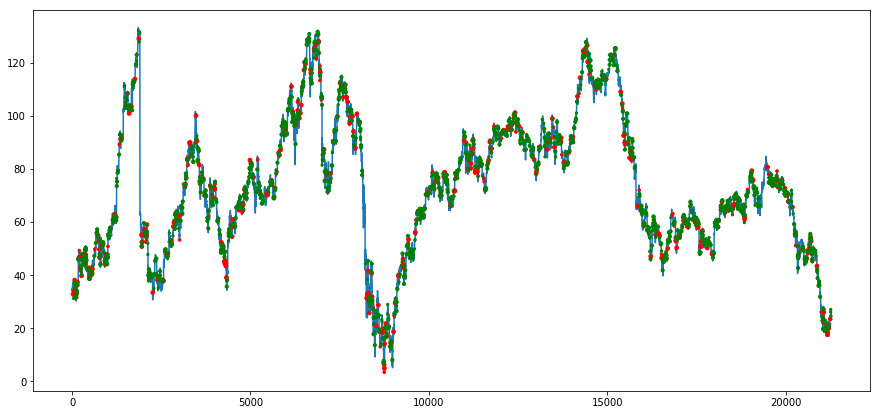

In [36]:
plt.figure(1, figsize=(15,7))
plt.plot(range(0, len(prices_train)), prices_train, zorder = 1)
plt.scatter(buy_time_train[n],  prices_train[buy_time_train[n]], s=np.array(buy_quantity_train[n]) *7, color='red', zorder = 2)
plt.scatter(sell_time_train[n],  prices_train[sell_time_train[n]], s=np.array(sell_quantity_train[n]) *5, color='green', zorder = 2)
plt.show()

In [23]:
n_cpu = 5
env = TradingEnvironment(df_test.Price,
                         normalized_incr_test,
                         initial_cash = 25000,
                         quantity = 4,
                         broker_commission=0.001,
                         max_cash_proportion = 10,
                         n_last_bars=N_LAST_BARS,
                         noise=True,
                         noise_perc=0.8)
env = SubprocVecEnv([lambda: env for i in range(n_cpu)])
env.reset()
obs = env.reset()
state = None
done = [False for _ in range(env.num_envs)]

buy_time_test = []
buy_quantity_test = []
sell_time_test = []
sell_quantity_test = []

for cpu in range(n_cpu):
    buy_time_test.append([])
    buy_quantity_test.append([])
    sell_time_test.append([])
    sell_quantity_test.append([])

for step_idx in range(df_test.shape[0] - N_LAST_BARS - 1):
    action, state = model.predict(obs, state=state, mask=done)
    obs, rewards , _, _ = env.step(action)
    
    for n, d in enumerate(done):
        timestep = env.get_attr('timestep')[n] + N_LAST_BARS
        valid_action = env.get_attr('valid_action')[n]
        main_action, quantity = action[n][0], action[n][1]
        if main_action == 0 and valid_action:
            buy_time_test[n].append(timestep)
            buy_quantity_test[n].append(quantity)
        elif main_action == 1 and valid_action: 
            sell_time_test[n].append(timestep)
            sell_quantity_test[n].append(quantity)

Episode step 244. Profit: -1486.2089399999968. Net Worth: 23513.791060000003. Shares: 27
Episode step 244. Profit: -2313.8740499999913. Net Worth: 22686.12595000001. Shares: 181
Episode step 244. Profit: -1453.747199999998. Net Worth: 23546.252800000002. Shares: 131
Episode step 244. Profit: -568.5395600000011. Net Worth: 24431.46044. Shares: 4
Episode step 244. Profit: -118.21768999999767. Net Worth: 24881.782310000002. Shares: 143
Episode step 744. Profit: -73.44871999998941. Net Worth: 24926.55128000001. Shares: 86
Episode step 744. Profit: 1807.3880300000092. Net Worth: 26807.38803000001. Shares: 47
Episode step 744. Profit: -1873.135019999987. Net Worth: 23126.864980000013. Shares: 3
Episode step 744. Profit: 617.7705000000133. Net Worth: 25617.770500000013. Shares: 33
Episode step 744. Profit: 66.07133000001704. Net Worth: 25066.071330000017. Shares: 130
Episode step 1244. Profit: -219.35874999998123. Net Worth: 24780.64125000002. Shares: 29
Episode step 1244. Profit: 897.6556100

In [24]:
n = 0

prices_test = df_test['Price'].values
prices_test.shape, len(buy_time_test[n]), len(sell_time_test[n])

((5270,), 124, 292)

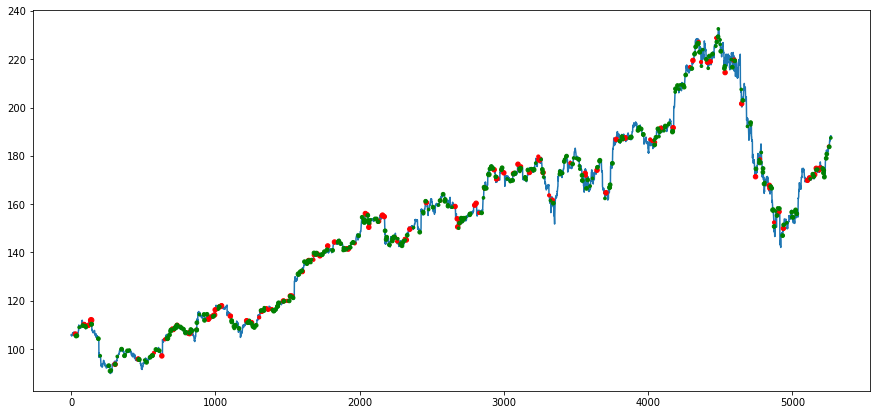

In [34]:
plt.figure(1, figsize=(15,7))
plt.plot(range(0, len(prices_test)), prices_test, zorder = 1)
plt.scatter(buy_time_test[n],  prices_test[buy_time_test[n]], s=np.array(buy_quantity_test[n]) *10, color='red', zorder = 2)
plt.scatter(sell_time_test[n],  prices_test[sell_time_test[n]], s=np.array(sell_quantity_test[n]) *7, color='green', zorder = 2)
plt.show()